# Denoising scRNA-seq using DCA

## scRNA-seq Simulation using Splatter R package and rpy2

In [1]:
# make sure that rpy2 is installed: https://rpy2.bitbucket.io/
%load_ext rpy2.ipython

import warnings
from rpy2.rinterface import RRuntimeWarning

# ignore R warning messages
warnings.filterwarnings("ignore", category=RRuntimeWarning)

### Simulate two groups using Splatter

In [2]:
%%R -o counts -o truecounts -o geneinfo -o cellinfo

# make sure that splatter is installed: https://github.com/Oshlack/splatter
library(splatter)

simulate <- function(nGroups=2, nGenes=200, batchCells=2000, dropout=3)
{
    if (nGroups > 1) method <- 'groups'
    else             method <- 'single'

    group.prob <- rep(1, nGroups) / nGroups
    sim <- splatSimulate(group.prob=group.prob, nGenes=nGenes, batchCells=batchCells,
                         dropout.present=(dropout != 0), method=method,
                         seed=42, dropout.shape=-1, dropout.mid=dropout)

    counts     <- as.data.frame(t(counts(sim)))
    truecounts <- as.data.frame(t(assays(sim)$TrueCounts))

    dropout    <- assays(sim)$Dropout
    mode(dropout) <- 'integer'

    cellinfo   <- as.data.frame(colData(sim))
    geneinfo   <- as.data.frame(rowData(sim))

    list(counts=counts,
         cellinfo=cellinfo,
         geneinfo=geneinfo,
         truecounts=truecounts)
}

sim <- simulate()

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

## Generate AnnData objects and analyze in Scanpy

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy.api as sc
import DCA.api as dca

Using TensorFlow backend.


In [4]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene
adata

AnnData object with n_obs × n_vars = 2000 × 200 
    obs_keys = ['Cell', 'Batch', 'Group', 'ExpLibSize']
    var_keys = ['Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2']

In [5]:
adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true

AnnData object with n_obs × n_vars = 2000 × 200 
    obs_keys = ['Cell', 'Batch', 'Group', 'ExpLibSize']
    var_keys = ['Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2']

In [6]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

## Denoise simulated data

In [7]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

res = dca.autoencode(adata_ae, training_kwargs={'verbose': False})

adata_ae.X = res['mean_norm']
sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.pp.pca(adata_ae)

adata_ae

### Autoencoder: Successfully preprocessed 200 genes and 2000 cells.
Calculating low dimensional representations...
Calculating reconstructions...
CPU times: user 1min 12s, sys: 17.9 s, total: 1min 30s
Wall time: 31.9 s


## PCA: Simulation with and without dropout effect

... storing 'Batch' as categorical type
    access categories as adata.obs['Batch'].cat.categories
... storing 'Group' as categorical type
    access categories as adata.obs['Group'].cat.categories


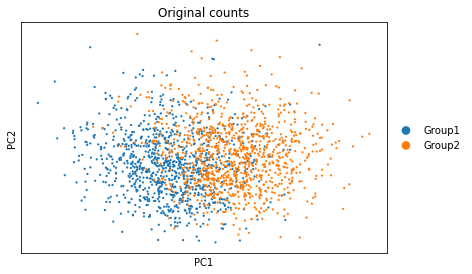

... storing 'Batch' as categorical type
    access categories as adata.obs['Batch'].cat.categories
... storing 'Group' as categorical type
    access categories as adata.obs['Group'].cat.categories


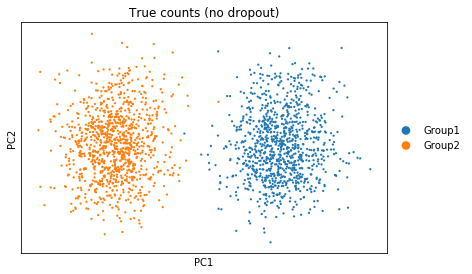

... storing 'Batch' as categorical type
    access categories as adata.obs['Batch'].cat.categories
... storing 'Group' as categorical type
    access categories as adata.obs['Group'].cat.categories


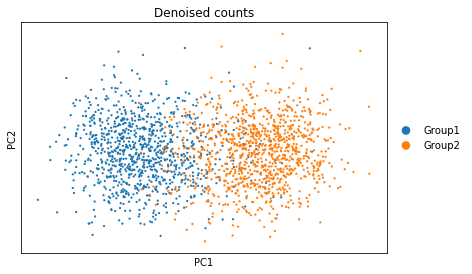

In [8]:
sc.pl.pca_scatter(adata, color='Group', size=20, title='Original counts')
sc.pl.pca_scatter(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.pca_scatter(adata_ae, color='Group', size=20, title='Denoised counts')

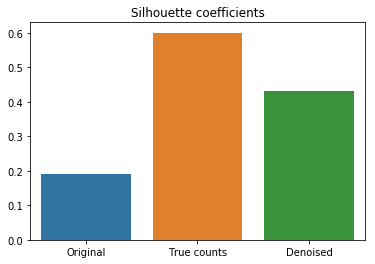

In [9]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm.X_pca[:, :2], adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm.X_pca[:, :2], adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm.X_pca[:, :2], adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], 
            y=[sil_orig, sil_true, sil_ae])

plt.title('Silhouette coefficients');

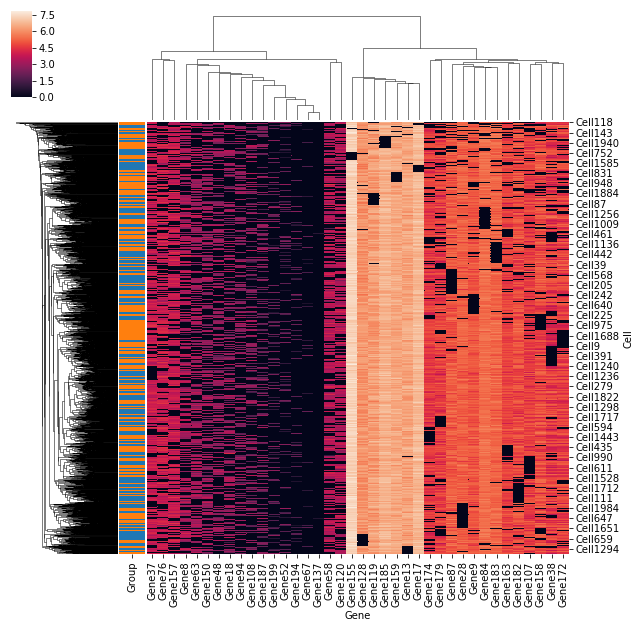

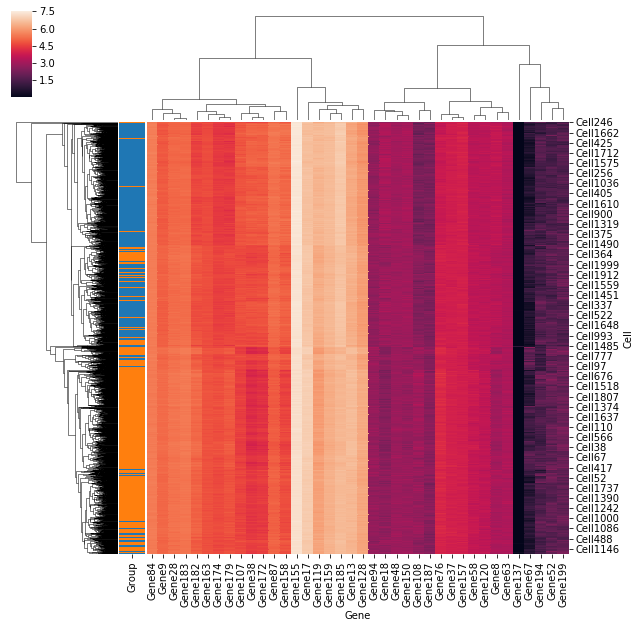

In [10]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup2'].values.sum(1) != 2.0)

sc.pl.clustermap(adata[:, de_genes], 'Group')
sc.pl.clustermap(adata_ae[:, de_genes], 'Group')

## Simulate six groups

In [11]:
%%R -o counts -o geneinfo -o cellinfo -o truecounts

sim <- simulate(nGroups=6, dropout=1)

counts <- sim$counts
geneinfo <- sim$geneinfo
cellinfo <- sim$cellinfo
truecounts <- sim$truecounts

In [12]:
adata = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata.obs_names = cellinfo.Cell
adata.var_names = geneinfo.Gene

adata_true = sc.AnnData(truecounts.values, obs=cellinfo, var=geneinfo)
adata_true.obs_names = cellinfo.Cell
adata_true.var_names = geneinfo.Gene
adata_true

AnnData object with n_obs × n_vars = 2000 × 200 
    obs_keys = ['Cell', 'Batch', 'Group', 'ExpLibSize']
    var_keys = ['Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6']

In [13]:
sc.pp.normalize_per_cell(adata)
sc.pp.normalize_per_cell(adata_true)

sc.pp.log1p(adata)
sc.pp.log1p(adata_true)

sc.pp.pca(adata)
sc.pp.pca(adata_true)

sc.tl.tsne(adata)
sc.tl.tsne(adata_true)

## Denoise simulated data

In [14]:
%%time

adata_ae = sc.AnnData(counts.values, obs=cellinfo, var=geneinfo)
adata_ae.obs_names = cellinfo.Cell
adata_ae.var_names = geneinfo.Gene

res = dca.autoencode(adata_ae, training_kwargs={'verbose': False})

adata_ae.X = res['mean_norm']
sc.pp.normalize_per_cell(adata_ae)
sc.pp.log1p(adata_ae)
sc.tl.tsne(adata_ae)

adata_ae

### Autoencoder: Successfully preprocessed 200 genes and 2000 cells.
Calculating low dimensional representations...
Calculating reconstructions...
         Falling back to preprocessing with `sc.pp.pca` and default params.
CPU times: user 1min 48s, sys: 24.1 s, total: 2min 12s
Wall time: 53.2 s


... storing 'Batch' as categorical type
    access categories as adata.obs['Batch'].cat.categories
... storing 'Group' as categorical type
    access categories as adata.obs['Group'].cat.categories


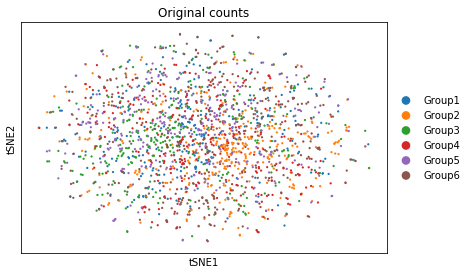

... storing 'Batch' as categorical type
    access categories as adata.obs['Batch'].cat.categories
... storing 'Group' as categorical type
    access categories as adata.obs['Group'].cat.categories


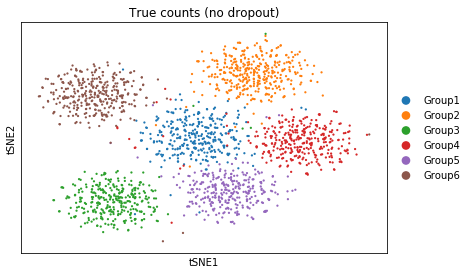

... storing 'Batch' as categorical type
    access categories as adata.obs['Batch'].cat.categories
... storing 'Group' as categorical type
    access categories as adata.obs['Group'].cat.categories


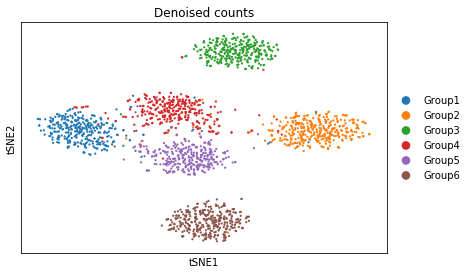

In [15]:
sc.pl.tsne(adata, color='Group', size=20, title='Original counts')
sc.pl.tsne(adata_true, color='Group', size=20, title='True counts (no dropout)')
sc.pl.tsne(adata_ae, color='Group', size=20, title='Denoised counts')

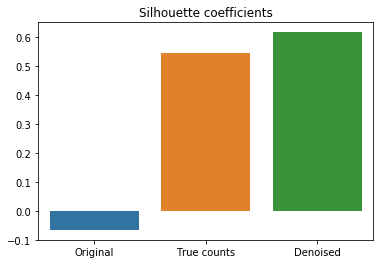

In [16]:
from sklearn.metrics import silhouette_score

sil_orig = silhouette_score(adata.obsm.X_tsne, adata.obs.Group)
sil_true = silhouette_score(adata_true.obsm.X_tsne, adata_true.obs.Group)
sil_ae = silhouette_score(adata_ae.obsm.X_tsne, adata_ae.obs.Group)

sns.barplot(x=['Original', 'True counts', 'Denoised'], y=[sil_orig, sil_true, sil_ae])
plt.title('Silhouette coefficients');

In [17]:
adata

AnnData object with n_obs × n_vars = 2000 × 200 
    obs_keys = ['Cell', 'Batch', 'Group', 'ExpLibSize', 'n_counts']
    var_keys = ['Gene', 'BaseGeneMean', 'OutlierFactor', 'GeneMean', 'DEFacGroup1', 'DEFacGroup2', 'DEFacGroup3', 'DEFacGroup4', 'DEFacGroup5', 'DEFacGroup6']
    uns_keys = ['Group_colors', 'pca']
    obsm_keys = ['X_pca', 'X_tsne']
    varm_keys = ['PCs']

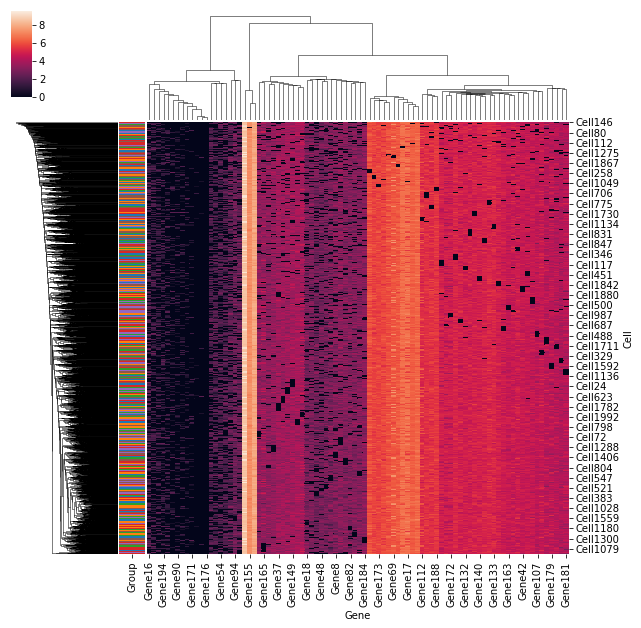

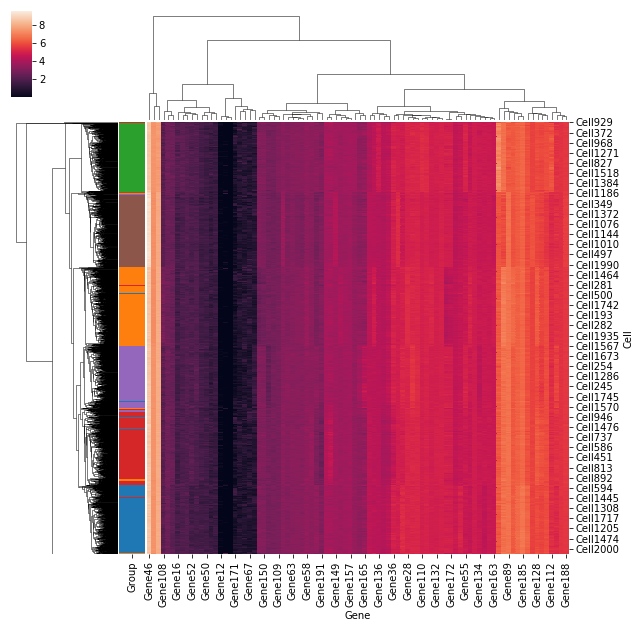

In [18]:
de_genes = (adata.var.loc[:, 'DEFacGroup1':'DEFacGroup6'].values.sum(1) != 6.0)

sc.pl.clustermap(adata[:, de_genes], 'Group')
sc.pl.clustermap(adata_ae[:, de_genes], 'Group')